# TensorFlow Quick Intro (for Humans)

In TF, data exists as tensors. These are computationally-optimized data types that represent matrices (or vectors).

TF doesn't run your program like a standard Python program.

It builds and then runs a mathematical representation, or **graph**. 

This is because, beneath the hood, TF is going to do the maths using an optimized engine that can map the calculations efficiently to a set of processors (e.g. GPU/TPU cores) running in parallel if possible (likely). 

In order to distribute the calculation across a set of processor nodes, TF needs a way to understand the topology of the calculation to begin with, hence the way that TF dictates a style of programming that declares the graph before running it.

Therefore, TF runs the graph calculation within a Session().

The following is a trivial example:

In [1]:
import tensorflow as tf

# Declare TensorFlow object called tensor
some_constant = tf.constant('This is TensorFlow!')

with tf.Session() as sess:
    # Run the tf.constant operation in the session
    output = sess.run(some_constant)
    print(output)

b'This is TensorFlow!'


Now, to feed it actual data, versus constants (which still might be useful), we need to create inputs to the graph. These are like ports where we can inject data over time, keeping in mind that for a neural network to be useful, we are going to stream data into it (from a large data source, most likely).

We need to be ready to stream data into TF and so we define inputs rather than input variables per se.

In Python we do this:

`x = some_data`

In TF, we don't set the data, but rather the shape (and type) of the data. We do this using placeholders.

In [2]:
# Some example placeholders - i.e. inputs for our graph
x = tf.placeholder(tf.string)
y = tf.placeholder(tf.int32)
z = tf.placeholder(tf.float32)

with tf.Session() as sess:
    output = sess.run(x,feed_dict={x: 'Test String', y: 123, z: 45.67})
print(output)

Test String


Wait, what?

What was that `feed_dict` thing?

That was us feeding some data to our placeholders.

This `sess.run` is asking TF to give us the output of a node (`x`) in our graph. In this case, we are asking for the output of the node `x`. 

Clearly, we don't need the other inputs to compute `x` so they are redundant, but illustrative for this trivial example.

We could do something like:

In [3]:
# Some example placeholders - i.e. inputs for our graph
a = tf.placeholder(tf.int32)
b = tf.placeholder(tf.int32)
c = a + b

with tf.Session() as sess:
    output = sess.run(c,feed_dict={a: 2, b:2})
print(output)

4


And, of course, the beauty of TF is that it can handle vectors (of any dimension):

In [4]:
with tf.Session() as sess:
    output = sess.run(c,feed_dict={a: [1,1,1,1], b:[1,1,1,1]})
print(output)

[2 2 2 2]


The `+` here is a scalar addition happening "bit-wise" across the array. For a truly multi-dimensional array addition, we need to use `tf.add`, which we do here for a 4x2 array addition.

In [5]:
c = tf.add(a,b)
with tf.Session() as sess:
    output = sess.run(c,feed_dict={a: [[1,1,1,1],[1,1,1,1]], b:[[1,1,1,1],[1,1,1,1]]})
print(output)

[[2 2 2 2]
 [2 2 2 2]]


Of course, this isn't that useful if we have to write the values in our code.

Ideally, we want to stream data into the inputs.

In [6]:
some_data = [
    [1, 1,],
    [2, 2,],
    [3, 3,],
    [4, 4,],
]
slices = tf.data.Dataset.from_tensor_slices(some_data)
next_slice = slices.make_one_shot_iterator().get_next()

In [7]:
with tf.Session() as sess:
    while True:
      try:
        val = sess.run(next_slice)
        print(sess.run(c,feed_dict={a: val, b:val}))
      except tf.errors.OutOfRangeError:
        break

[2 2]
[4 4]
[6 6]
[8 8]


# Neural Layers

Thus far we've shown how we can setup inputs to a graph and feed data into them, including from a "stream".

Of course, for this to be useful for a neural network, we need to feed data into a layer and do something useful.

The most common operation in neural networks is calculating the linear combination of inputs, weights, and biases. As a reminder, we can write the output of the linear operation as

![](linear-equation.gif)

Here, $\textbf{W}$ is a matrix of the weights connecting two layers. The output $\textbf{y}$, the input $\textbf{x}$, and the biases $\textbf{b}$ are all vectors.

Firstly, let's implement this ourselves using graph math.

In [8]:
x = tf.placeholder(tf.float32)
w = tf.placeholder(tf.float32)
b = tf.placeholder(tf.float32)
y = tf.add(tf.matmul(x, w), b)

Note that we had to use `tf.matmul()` here because we are multiplying matrices, not scalars.

Now let's run this, but set our weights to 1s and our bias to 0.

In [9]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    sess.run(y, feed_dict={x:some_data, w:[[1],[1]],b:[[0]]})

array([[2.],
       [4.],
       [6.],
       [8.]], dtype=float32)

This is as expected.

We are multiplying each input by 1 and adding 0.

* `1*1 + 1*1 + 0 = 2`
* `2*1 + 2*1 + 0 = 4`
* `3*1 + 3*1 + 0 = 6`
* `4*1 + 4*1 + 0 = 8`

However, if we want to train our layer to give us a desired result (whatever that is going to be) then we need our weights and biases to be variables that we can updae on each iteration during training.

Therefore, we use a different approach to initialize these variables using the `tf.Variable` method.

In [10]:
w = tf.Variable(tf.ones((2, 1)))
b = tf.Variable(tf.zeros(1))
y = tf.add(tf.matmul(x, w), b)

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    sess.run(y, feed_dict={x:some_data})

array([[2.],
       [4.],
       [6.],
       [8.]], dtype=float32)

Furthermore, we don't know what the weights should be and so we need to initialize them to some values.

For now, we will follow the heuristic that often works fine with training, which is to set the weights to some random (normalized) values and set the biases to all 0s. We are setting `seed=1` to control the random number generator so that we can get repeatable results later.

In [11]:
w = tf.Variable(tf.truncated_normal((2, 1),seed=1))
b = tf.Variable(tf.zeros(1))
y = tf.add(tf.matmul(x, w), b)

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    output = sess.run(y, feed_dict={x:some_data})
    print(output)

[[0.67328054]
 [1.3465611 ]
 [2.0198417 ]
 [2.6931221 ]]


## Using the Dense model

Our desire to use a linear model of the type $\textbf{y = Wx + b}$ is common enough that TF has a built-in graph primitive called `Dense`. It is a layer of perceptrons.

Here we declare our model by declaring a `layer` of type `Dense`.

We set `units=1` for our single output and here we override the default weights (usually random) so that we achieve the same function as before.


In [12]:
x = tf.placeholder(tf.float32, shape=[None, 2])
linear_model = tf.layers.Dense(units=1,kernel_initializer=tf.truncated_normal_initializer(seed=1))
y_dense = linear_model(x)

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    dense_output = sess.run(y_dense, {x: some_data})
    print(dense_output)

[[0.67328054]
 [1.3465611 ]
 [2.0198417 ]
 [2.6931221 ]]


In [13]:
# were the two approaches the same?
dense_output == output

array([[ True],
       [ True],
       [ True],
       [ True]])

What we haven't mentioned yet is the function `global_variables_initializer()`

This is to initialize the variables (i.e. weights and biases) before we can run the graph. Otherwise the weights and biases will be uninitialized (unset) and so the graph session will crash.

Note that for initializing variables, there are a number of [initializers](https://www.tensorflow.org/api_docs/python/tf/initializers) that we could use.

# Training

Now let's try our hand at a simple neural network with some training data.

Now we will attempt to build a classifier using TF.

To make things easy to understand and follow, I wrote a small [script](generate_shapes.ipynb) to produce some basic 28x28 pixel shapes, either cirles or squares. They are differing sizes and not fully formed - i.e. pixelated (mostly by image reduction). This will allow you play around with shape manipulation (e.g. try rotating or distoring the shapes) to see how well your network performs with noiser or cleaner data. The default data here is pretty clean.

I have also resized everything to the "canonical" 28x28 that is commonly used for MNIST and similar datasets so that you are already mentally attuned to how the sizing of features (for those kinds of 2D images) works.

The data is already prepared ready for TF. This means that each shape has been converted to a 784 Numpy array where the pixel values range from 0.1 to 0.9 (i.e. have been normalized). Moreover, I have also used the `LabelBinarizer`
and `train_test_split` from `sklearn` to one-hot encode the labels and create the required training, validation and test data sets.

But so we understand what's going on, let's look at a simple `Dense` layer to process one image.

We are going to present each image as an example to the graph. To do that, we present **all 784 pixels at once**. Therefore, we immediately know that we need 784 inputs.

Because our shapes are either circles or squares, we want to train the graph to recognize the presence of either one of these, which means we need two outputs.

Let's load the data first, which was saved as a pickle file:

In [14]:
%matplotlib inline
import pickle
import math

import numpy as np
#import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt

pickle_file = 'shape_data.pickle'
with open(pickle_file, 'rb') as f:
  pickle_data = pickle.load(f)
  train_features = pickle_data['train_dataset']
  train_labels = pickle_data['train_labels']
  valid_features = pickle_data['valid_dataset']
  valid_labels = pickle_data['valid_labels']
  test_features = pickle_data['test_dataset']
  test_labels = pickle_data['test_labels']
  del pickle_data  # Free up memory
    

# Make sure the TF graph is reset so we can inspect it later
tf.reset_default_graph()

Now let's look at a random selection of shapes to see what we're dealing with:

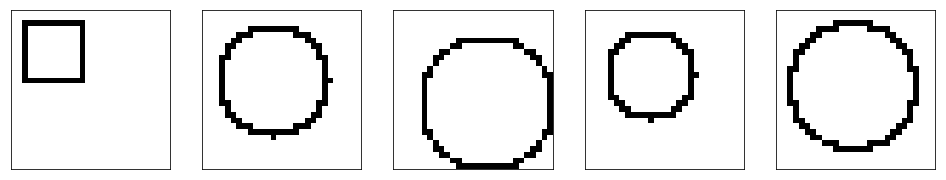

In [15]:
import random
fig = plt.figure(figsize=(20,20))
for i in range(1,6):
    ax = fig.add_subplot(1, 6, i, xticks=[], yticks=[])
    ax.imshow(np.reshape(train_features[random.randint(0,10000)],(28,28)), cmap='gray')
#ax = fig.add_subplot(1, 6, 2, xticks=[], yticks=[])
#ax.imshow(np.reshape(train_features[random.randint(0,10000)],(28,28)), cmap='gray')

Notice that the squares are very well defined and the circles less so, but clearly they are very distinct. One can almost imagine how certain input patterns (like long run-lengths of black pixels) should create a higher probability of a `square==1` but we aren't really too interested in how it works for now (but this might be more interesting to inspect if trying out a Convolutional Neural Network later).

Now let's set up a trivial dense layer with our 784 inputs and 2 outputs.

We will set the weights to be 1s and leave the default biases as 0s. Without attempting to change these yet, this means we expect the layer to act as a simple accumulator (or adder) for the inputs. Both outputs will be identical.

Let's check:

In [16]:
input_shape = tf.placeholder(tf.float32, shape=[None, 784])
shape_classifier = tf.layers.Dense(units=2,kernel_initializer=tf.ones_initializer())
y_shape = shape_classifier(input_shape)

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    shape_output = sess.run(y_shape, {input_shape: [train_features[0]]})
    print(shape_output)

[[738.8 738.8]]


If we sum the values of the input shape pixel values, they should add up to the same number:

In [17]:
np.sum(train_features[0])

738.8

Of course, we don't want the outputs to be merely the sum of the pixels. It is pretty obvious that this won't tell us anything much about the shape, except perhaps how much of the image has darker pixels (which would be a lower sum).

First of all, let's get the output looking something like it's trying to predict the probability of either a circle or a square. To do that, we will use a softmax output.

This looks at the values and adjusts them so they are similarly proportioned, except all add up to 1. Therefore the output of each is a kind of probability.

In [18]:
# define our graph
tf.reset_default_graph()

input_shape = tf.placeholder(tf.float32, shape=[None, 784])
shape_classifier = tf.layers.Dense(units=2,kernel_initializer=tf.ones_initializer())
y_shape = shape_classifier(input_shape)
softmax = tf.nn.softmax(y_shape)

#initialize our graph
init = tf.global_variables_initializer()
# run our graph
with tf.Session() as sess:
    sess.run(init)
    shape_output = sess.run(softmax, {input_shape: [train_features[0]]})
    print(shape_output)


[[0.5 0.5]]


For the way we've currently set up the graph, these answers are correct - i.e. there's a 50/50 chance of it being either shape. This is meaningless of course because both graphs are the same.

In [19]:
# reset our graph
tf.reset_default_graph()

# Set the number of features - i.e. the pixels in each input shape
features_count = 784
# How many classes? Two shapes...
classes_count = 2

# Now set up our placeholder for the input shape (features)
input_shape = tf.placeholder(tf.float32, shape=[None, 784])

# And now for the one-hot encoded labels
labels = tf.placeholder(tf.float32)

# Now set up our layer of neurons (perceptrons)
# We only need two units for the two type of shape (one-hot encoded)
softmax = tf.layers.dense(input_shape, units=2,activation=tf.nn.softmax)

Note that this time we told TF to set the layer's activation function to be `tf.nn.softmax` which is a callable function that performs the softmax distribution on the outputs for us. It just means we can skip the separate step that we had above.

## Figuring out the Error (or Loss)

The cross-entropy of a neural network is fancy name for a measure of how well it's classifying. 
In layman's terms, it's the product of all the `softmax` probabilities that the network predicts weighted by the actual values (`labels`) to reward correct predictions and punish bad ones. 

For computational efficiency (mostly precision), we want to avoid products and use summation. We can do this by taking the logs of the probabilities and then summing the logs.

Fortunately, this function is easy to compute with TF using [`reduce_sum`](https://www.tensorflow.org/api_docs/python/tf/reduce_sum) which sums across all the input tensor elements.

Of course, we then want to know the average (mean) of the sums so that we can see overall how well our graph is doing. We can call this the `loss`.

In [20]:
# Cross entropy
cross_entropy = -tf.reduce_sum(labels * tf.log(softmax), axis=1)

# Training loss
loss = tf.reduce_mean(cross_entropy)

## Preparing to Measure Accuracy

Once we set our graph in motion by streaming the inputs in a `Session.run()` we want to keep track of how well it's performing. The loss is one measure of course, but is a metric and not the accuracy per se. 

For the accuracy, we will want to first see if our prediction was correct.

We can't simply use a python test like `softmax == label` because we are dealing with tensors (i.e. vectors) and what we want to know is whether the highest probability output (in this case of the two possible outputs) aligns with the `1` in the softmax vector.

To do this, we could see which of the softmax outputs is the highest, as this gives us the graph's prediction and then which of the label's values is the highest. If these align (i.e. the maximums) then we can say that the prediction is correct.

In other words, say softmax is `[0.1, 0.9]`, then the max value is at `index=1` in the tensor.

Now let's say that the label is `[0.0, 1.0]` then we see that the max is also at `index=1` (or aligned in terms of one-hot encoding) and so we can say that this is a correct prediction.

TF gives us a function called [`argmax`](https://www.tensorflow.org/api_docs/python/tf/arg_max) to calculate which of the indexes has the maxium value. We then calculate if they are aligned - i.e. equal.

We then want to add up all the right answers and divide by the total number of predictions to get a running average. We can't just compute an average of the prediction test (`tf.equal`) because the answer is `boolean`. We therefore convert this to a floating point value using `tf.cast`

Don't forget that this code below is **not** going to run now. It is merely setting up part of the graph. So long as we feed it with the correct data streams (`softmax, labels`) during a session, it will compute the accuracy for us.

In [21]:
# # Determine if the predictions are correct
is_correct = tf.equal(tf.argmax(softmax, 1), tf.argmax(labels, 1))
# # Calculate the accuracy of the predictions
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

Before we start to build our trainable graph, we need to understand a few things about TF. 

It makes some assumptions. One of them is that the `Dense` layer has two tensors that are variables and therefore trainable. We can inspect [trainable tensors](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) as follows:

In [22]:
tf.trainable_variables()

[<tf.Variable 'dense/kernel:0' shape=(784, 2) dtype=float32_ref>,
 <tf.Variable 'dense/bias:0' shape=(2,) dtype=float32_ref>]

## Back Propagation

This is what we expect because we can see that these tensors are the kernel (i.e. weights) and biases for our `Dense` layer. We can see here that without us doing anything, TF has already assigned a tensor for the weights (`kernel`) and a tensor for the biases (`bias`).

This is important because now we are getting to the crux of the graph, which is the ability for it to learn.

How is this going to happen?

As you hopefully know, the learning is a process of tweaking the weights and biases until a set is found that minimizes the overall error, or what we have called `loss` above.

In this example, we will use Mini-Batch Gradient Descent to try and find a minimum for `loss` as a function of the weights and biases. This is done by calculating the gradient of that function and then adjusting the weights in the direction of downward slope (hopefully towards a minimum) for each batch of training shapes. The optimization is via the process of back propagation.

Rather beautifully, TF can do all this for us so that we don't have to figure out how to differentiate the activation function and so on. We simply set up a training optimizer.

How fast we attempt to climb down the slope is set by the step size, or what we call the `learning rate`, so we have to set this value. Of course, there is no way of knowing in advance what to set it to, so we will take a guess initially. But you will notice by playing with it that the rate can dramatically affect the results, including getting no useful results at all (due to overshoot).

In [23]:
# play around with this later to see what it does
learning_rate = 0.05
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

# Running the Training

To train our network, we need to repeatedly feed the training vectors into the graph and run backprop to calculate the new weights using the Stochastic Gradient Descent optimizer.



In [24]:
#initialize our graph - i.e. set up the Dense layer (e.g. the weights/biases)
init = tf.global_variables_initializer()

# Feed dicts for training, validation, and test session
train_feed_dict = {input_shape: train_features, labels: train_labels}
valid_feed_dict = {input_shape: valid_features, labels: valid_labels}
test_feed_dict = {input_shape: test_features, labels: test_labels}

# How many samples we feed through the graph before we update the model
# Pay with this value later
batch_size = 128
# How many times we will train the network (and see how that improves our model)
# Pay with this value later
n_epochs = 4 

# The validation accuracy - i.e. how well do our validation samples do during training, per epoch
validation_accuracy = 0.0

# Measurements use for graphing loss and accuracy
batch_logging_sizes = 64
batches = []
loss_batch = []
train_acc_batch = []
valid_acc_batch = []

batch_count = int(math.ceil(len(train_features)/batch_size))
print('{} training samples; {} batches of size:{}'.format(len(train_features),batch_count,batch_size))

95000 training samples; 743 batches of size:128


Epoch 1/4 with validation accuracy 0.0: 100%|██████████| 743/743 [00:02<00:00, 356.97batches/s]
Epoch 2/4 with validation accuracy 0.8849999904632568: 100%|██████████| 743/743 [00:02<00:00, 359.22batches/s]
Epoch 4/4 with validation accuracy 1.0: 100%|██████████| 743/743 [00:02<00:00, 352.82batches/s]


Text(0.5,1,'Loss')

(64, 3072)

Text(0.5,1,'Accuracy')

(0, 1.0)

(64, 3072)

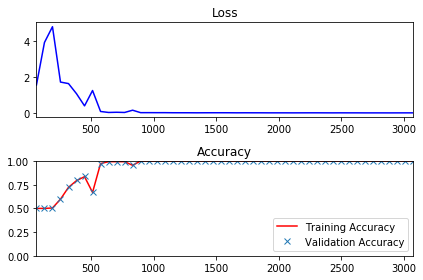

In [25]:
with tf.Session() as session:
    session.run(init)
    # figure out how many training vectors we need per batch
    # Do some rounding to an integer
    

    for ith_epoch in range(n_epochs):
        
        # Progress bar - so we get a progress bar using the Python TQDM lib
        # It's just a wrapper for our range
        batch_progress = tqdm(range(batch_count), desc='Epoch {}/{} with validation accuracy {}'.
                              format(ith_epoch+1, n_epochs,validation_accuracy), unit='batches')
        
        # The training cycle
        for ith_batch in batch_progress:
            # Get a batch of training features and labels
            batch_start = ith_batch*batch_size # our pointer (index) into the entire feature set
            batch_features = train_features[batch_start:batch_start + batch_size]
            batch_labels = train_labels[batch_start:batch_start + batch_size]

            # Run optimizer and get loss for batch_size of features
            _, l = session.run(
                [optimizer, loss],
                feed_dict={input_shape: batch_features, labels: batch_labels})

            # Log accuracy every log_batch_step batches - no need to calculate each loop
            # But this has nothing to do with the training, just the monitoring of performance
            if not ith_batch % batch_logging_sizes:
                # Calculate Training and Validation accuracy
                training_accuracy = session.run(accuracy, feed_dict=train_feed_dict)
                validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)

                # Log batches so that we can plot them
                previous_batch = batches[-1] if batches else 0
                batches.append(batch_logging_sizes + previous_batch)
                loss_batch.append(l)
                train_acc_batch.append(training_accuracy)
                valid_acc_batch.append(validation_accuracy)

        # Check accuracy against Validation data
        validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)

loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(batches, loss_batch, 'b')
loss_plot.set_xlim([batches[0], batches[-1]])
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
acc_plot.plot(batches, valid_acc_batch, 'x', label='Validation Accuracy')
acc_plot.set_ylim([0, 1.0])
acc_plot.set_xlim([batches[0], batches[-1]])
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()

We can see that it converged fairly quickly on a highly accurate model that is able to predict shapes all of the time. This is to be expected given the highly dissimilar (orthogonal) nature of the training data and the amount of it. We contrived this example to make things easy (and mostly instructive) for ourselves as an entry point into the world of TF.

# Test Accuracy

In our original dataset, we generated an independent set of shapes that the network hasn't seen before during training. (Well, given the way we generate shapes, it is highly likely that the network **has** seen these shapes, but let's ignore that for this lesson.)

Now we re-run the network, but with the test data and don't bother calculating `loss` because we are no longer optimizing, but rather presenting data to see what the network predicts.

In [27]:
# The accuracy measured against the test set
test_accuracy = 0.0

with tf.Session() as session:
    
    session.run(init)
    batch_count = int(math.ceil(len(train_features)/batch_size))

    for ith_epoch in range(n_epochs):
        
        # Progress bar
        batches_prog = tqdm(range(batch_count), desc='Epoch {}/{}'.format(ith_epoch+1, n_epochs), unit='batches')
        
        # The training cycle
        for ith_batch in batches_prog:
            # Get a batch of training features and labels
            batch_start = ith_batch*batch_size
            batch_features = train_features[batch_start:batch_start + batch_size]
            batch_labels = train_labels[batch_start:batch_start + batch_size]

            # Run optimizer
            _ = session.run(optimizer, feed_dict={input_shape: batch_features, labels: batch_labels})

        # Check accuracy against Test data
        test_accuracy = session.run(accuracy, feed_dict=test_feed_dict)

print('Test Accuracy:{}'.format(test_accuracy))

Epoch 4/4: 100%|██████████| 743/743 [00:00<00:00, 1743.27batches/s]

Test Accuracy:1.0
